<a href="https://colab.research.google.com/github/Canihelpme/DeepLearning_finance/blob/main/LSTM_Kospi_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import os
from pathlib import Path

folder = ""
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive


## 필요한 모듈 import

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [56]:
%matplotlib inline
filename = '/content/drive/MyDrive/Financial_data/Data/train/ko_train.csv'
data = pd.read_csv(filename, sep=",",encoding='UTF-8')
data.head

<bound method NDFrame.head of                Date       End      Open      High       Low   Amount     Val
0     2020년 02월 21일  2,162.84  2,165.65  2,184.43  2,160.28  635.47M  -1.49%
1     2020년 02월 20일  2,195.50  2,223.55  2,228.18  2,186.72  709.56M  -0.67%
2     2020년 02월 19일  2,210.34  2,222.51  2,226.00  2,191.20  591.16M   0.07%
3     2020년 02월 18일  2,208.88  2,225.98  2,232.93  2,205.21  470.42M  -1.48%
4     2020년 02월 17일  2,242.17  2,243.07  2,250.05  2,230.26  458.25M  -0.06%
...             ...       ...       ...       ...       ...      ...     ...
5994  1996년 04월 25일    964.69    957.56    977.44    957.56   57.17M   0.84%
5995  1996년 04월 24일    956.61     940.5    956.65    934.53   46.24M   1.71%
5996  1996년 04월 23일    940.55    951.47    957.95    940.55   52.69M  -1.06%
5997  1996년 04월 22일    950.61    941.75    957.61    941.75   57.15M   0.95%
5998  1996년 04월 20일    941.69     948.6    952.21    941.66   42.81M  -0.70%

[5999 rows x 7 columns]>

In [57]:
date_index = data
date_index = date_index.copy()
print(date_index)

               Date       End      Open      High       Low   Amount     Val
0     2020년 02월 21일  2,162.84  2,165.65  2,184.43  2,160.28  635.47M  -1.49%
1     2020년 02월 20일  2,195.50  2,223.55  2,228.18  2,186.72  709.56M  -0.67%
2     2020년 02월 19일  2,210.34  2,222.51  2,226.00  2,191.20  591.16M   0.07%
3     2020년 02월 18일  2,208.88  2,225.98  2,232.93  2,205.21  470.42M  -1.48%
4     2020년 02월 17일  2,242.17  2,243.07  2,250.05  2,230.26  458.25M  -0.06%
...             ...       ...       ...       ...       ...      ...     ...
5994  1996년 04월 25일    964.69    957.56    977.44    957.56   57.17M   0.84%
5995  1996년 04월 24일    956.61     940.5    956.65    934.53   46.24M   1.71%
5996  1996년 04월 23일    940.55    951.47    957.95    940.55   52.69M  -1.06%
5997  1996년 04월 22일    950.61    941.75    957.61    941.75   57.15M   0.95%
5998  1996년 04월 20일    941.69     948.6    952.21    941.66   42.81M  -0.70%

[5999 rows x 7 columns]


In [58]:
date_index['Date'] = date_index.Date.apply(str).str.replace("년","").str.replace("월","").str.replace("일","")
date_index['Date'] = date_index.Date.str.replace(" ","")

date_index['Amount'] = date_index.Amount.apply(str).str.replace("B", "0000000").str.replace("M","0000").str.replace("K","0").str.replace(".","")
date_index['Amount'] = date_index.Amount.astype(int)

date_index['End'] = date_index.End.apply(str).str.replace(",","").astype(float)
date_index['Open'] = date_index.Open.apply(str).str.replace(",","").astype(float)
date_index['High'] = date_index.High.apply(str).str.replace(",","").astype(float)
date_index['Low'] = date_index.Low.apply(str).str.replace(",","").astype(float)

date_index = date_index.loc[::-1].reset_index(drop=True)
print(date_index)

          Date      End     Open     High      Low     Amount     Val
0     19960420   941.69   948.60   952.21   941.66   42810000  -0.70%
1     19960422   950.61   941.75   957.61   941.75   57150000   0.95%
2     19960423   940.55   951.47   957.95   940.55   52690000  -1.06%
3     19960424   956.61   940.50   956.65   934.53   46240000   1.71%
4     19960425   964.69   957.56   977.44   957.56   57170000   0.84%
...        ...      ...      ...      ...      ...        ...     ...
5994  20200217  2242.17  2243.07  2250.05  2230.26  458250000  -0.06%
5995  20200218  2208.88  2225.98  2232.93  2205.21  470420000  -1.48%
5996  20200219  2210.34  2222.51  2226.00  2191.20  591160000   0.07%
5997  20200220  2195.50  2223.55  2228.18  2186.72  709560000  -0.67%
5998  20200221  2162.84  2165.65  2184.43  2160.28  635470000  -1.49%

[5999 rows x 7 columns]


In [59]:
date_index['Date'] = pd.to_datetime(date_index['Date'], format='%Y%m%d')
#date_index['year'] = date_index['date'].dt.year
date_index = date_index.set_index('Date')
print(date_index)

                End     Open     High      Low     Amount     Val
Date                                                             
1996-04-20   941.69   948.60   952.21   941.66   42810000  -0.70%
1996-04-22   950.61   941.75   957.61   941.75   57150000   0.95%
1996-04-23   940.55   951.47   957.95   940.55   52690000  -1.06%
1996-04-24   956.61   940.50   956.65   934.53   46240000   1.71%
1996-04-25   964.69   957.56   977.44   957.56   57170000   0.84%
...             ...      ...      ...      ...        ...     ...
2020-02-17  2242.17  2243.07  2250.05  2230.26  458250000  -0.06%
2020-02-18  2208.88  2225.98  2232.93  2205.21  470420000  -1.48%
2020-02-19  2210.34  2222.51  2226.00  2191.20  591160000   0.07%
2020-02-20  2195.50  2223.55  2228.18  2186.72  709560000  -0.67%
2020-02-21  2162.84  2165.65  2184.43  2160.28  635470000  -1.49%

[5999 rows x 6 columns]


## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
 !pip install finance-datareader

     |████████████████████████████████| 48 kB 2.4 MB/s 


In [3]:
import FinanceDataReader as fdr

In [13]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니, 

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [14]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [61]:
#stock = fdr.DataReader(STOCK_CODE)
stock = date_index

In [62]:
stock.head()

,End,Open,High,Low,Amount,Val
Date,,,,,,
1996-04-20,941.69,948.60,952.21,941.66,42810000,-0.70%
1996-04-22,950.61,941.75,957.61,941.75,57150000,0.95%
1996-04-23,940.55,951.47,957.95,940.55,52690000,-1.06%
1996-04-24,956.61,940.50,956.65,934.53,46240000,1.71%
1996-04-25,964.69,957.56,977.44,957.56,57170000,0.84%


In [63]:
stock.tail()


,End,Open,High,Low,Amount,Val
Date,,,,,,
2020-02-17,2242.17,2243.07,2250.05,2230.26,458250000,-0.06%
2020-02-18,2208.88,2225.98,2232.93,2205.21,470420000,-1.48%
2020-02-19,2210.34,2222.51,2226.00,2191.20,591160000,0.07%
2020-02-20,2195.50,2223.55,2228.18,2186.72,709560000,-0.67%
2020-02-21,2162.84,2165.65,2184.43,2160.28,635470000,-1.49%


In [64]:
stock.index

DatetimeIndex(['1996-04-20', '1996-04-22', '1996-04-23', '1996-04-24',
               '1996-04-25', '1996-04-26', '1996-04-27', '1996-04-29',
               '1996-04-30', '1996-05-02',
               ...
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21'],
              dtype='datetime64[ns]', name='Date', length=5999, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [65]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [66]:
stock.head()

,End,Open,High,Low,Amount,Val,Year,Month,Day
Date,,,,,,,,,
1996-04-20,941.69,948.60,952.21,941.66,42810000,-0.70%,1996,4,20
1996-04-22,950.61,941.75,957.61,941.75,57150000,0.95%,1996,4,22
1996-04-23,940.55,951.47,957.95,940.55,52690000,-1.06%,1996,4,23
1996-04-24,956.61,940.50,956.65,934.53,46240000,1.71%,1996,4,24
1996-04-25,964.69,957.56,977.44,957.56,57170000,0.84%,1996,4,25


## 시각화

Text(0, 0.5, 'price')

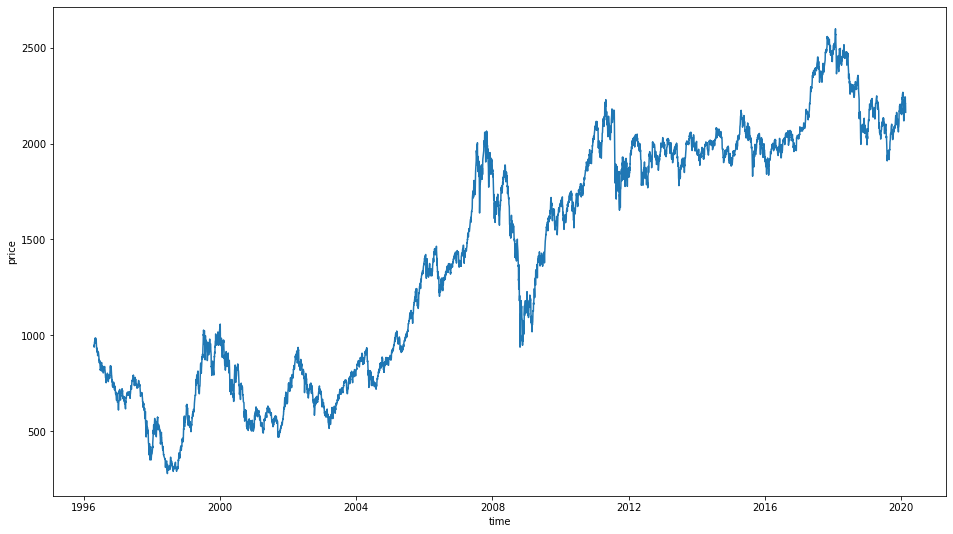

In [68]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['End'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

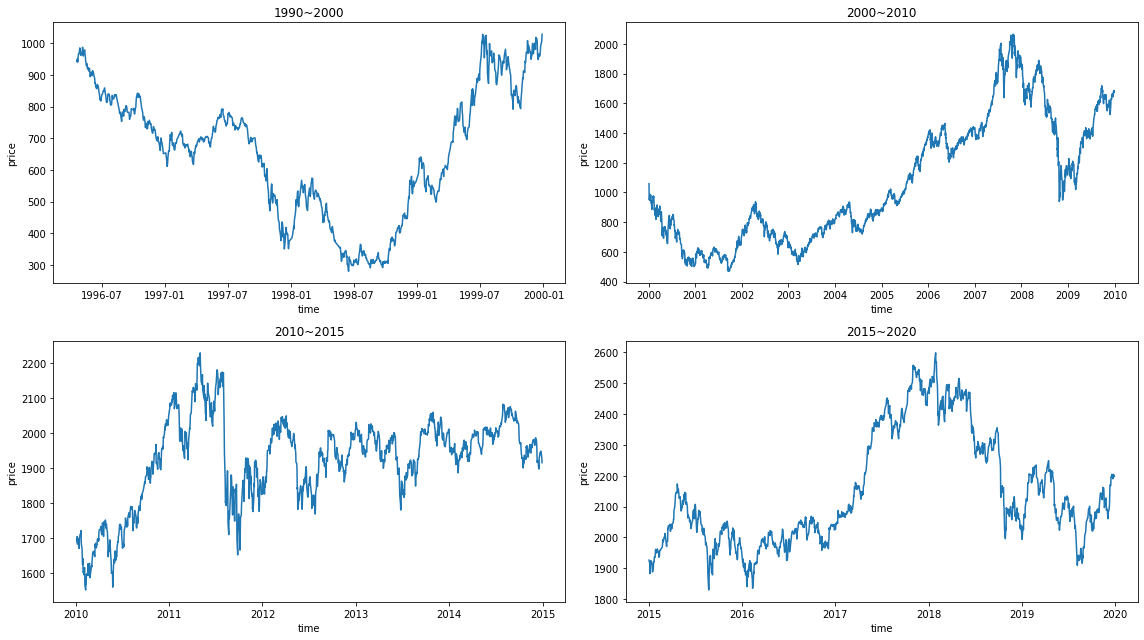

In [69]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['End'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = [ 'Open', 'High', 'Low','End', 'Amount']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.2883355 , 0.28548113, 0.28754902, 0.28543389, 0.01791633],
       [0.28536628, 0.28781265, 0.28758798, 0.28928172, 0.02394197],
       [0.28957954, 0.28795945, 0.28706854, 0.28494213, 0.02206789],
       ...,
       [0.84052883, 0.83545544, 0.82843328, 0.83269275, 0.24833216],
       [0.84097963, 0.83639669, 0.82649404, 0.8262912 , 0.29808366],
       [0.8158821 , 0.81750709, 0.81504904, 0.81220262, 0.26695115]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [80]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('End', 1), df['End'], test_size=0.2, random_state=0, shuffle=False)

In [83]:
x_train.shape, y_train.shape

((4799, 4), (4799,))

In [84]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [85]:
x_train

,Open,High,Low,Amount
0,0.288336,0.285481,0.287549,0.017916
1,0.285366,0.287813,0.287588,0.023942
2,0.289580,0.287959,0.287069,0.022068
3,0.284824,0.287398,0.284463,0.019358
4,0.292219,0.296374,0.294432,0.023950
...,...,...,...,...
4794,0.755674,0.749643,0.752976,0.188580
4795,0.755609,0.752242,0.753513,0.184630
4796,0.762419,0.758127,0.759625,0.233529
4797,0.759423,0.754733,0.756335,0.228011


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

---



---



In [86]:
import tensorflow as tf

In [87]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [88]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [89]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [90]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [92]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [93]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [94]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 3s 8ms/step - loss: 0.0016 - mse: 0.0032
Epoch 1: val_loss improved from inf to 0.00023, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 4s 14ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 2.3278e-04 - val_mse: 4.6555e-04
Epoch 2/50
146/150 [============================>.] - ETA: 0s - loss: 1.5740e-04 - mse: 3.1479e-04
Epoch 2: val_loss did not improve from 0.00023
150/150 [==============================] - 2s 10ms/step - loss: 1.5709e-04 - mse: 3.1418e-04 - val_loss: 2.7082e-04 - val_mse: 5.4164e-04
Epoch 3/50
148/150 [============================>.] - ETA: 0s - loss: 1.4655e-04 - mse: 2.9310e-04
Epoch 3: val_loss did not improve from 0.00023
150/150 [==============================] - 1s 9ms/step - loss: 1.4578e-04 - mse: 2.9156e-04 - val_loss: 2.3701e-04 - val_mse: 4.7403e-04
Epoch 4/50
141/150 [===========================>..] - ETA: 0s - loss: 1.4167e-04 - mse: 2.8334e-04
Epoch 4: val_loss did not improve from 0.00023
1

저장한 ModelCheckpoint 를 로드합니다.

In [95]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.




In [96]:
pred = model.predict(test_data)

In [97]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

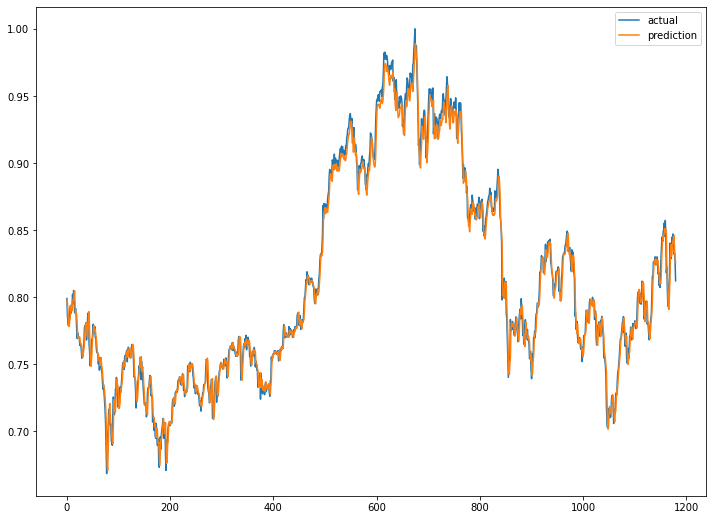

In [98]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()